In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [2]:
dataset = pp.load_dataset("adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note = pp.dicts_from_songs(ClassicSongs)
velocity_range, tick_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)

print("Number of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nVelocity range      :",velocity_range[0],velocity_range[1],"\nTime ticks range    :",tick_range[0],tick_range[1])

Couldn't load : adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load : adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load : adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio Babibino Caro.mid
Couldn't load : adl-piano-midi\Classical\Classical\Jean-Baptiste Lully\Minuet.mid
Couldn't load : adl-piano-midi\Classical\Classical\

In [3]:
AllChannels = np.array([])
AllNotes = np.array([])
AllVelocities = np.array([])
AllTicks = np.array([])
for song in ClassicSongs.values():
    AllChannels = np.append(AllChannels,song[:,0])
    AllNotes = np.append(AllNotes,song[:,1])
    AllVelocities = np.append(AllVelocities,song[:,2])
    AllTicks = np.append(AllTicks,song[:,3])

OneHotChannels = pp.one_hot_encode(channel_to_ind,AllChannels)
OneHotNotes = pp.one_hot_encode(note_to_ind,AllNotes)
AllVelocities = AllVelocities.reshape((-1,1))
AllTicks = AllTicks.reshape((-1,1))

In [4]:
seq_length = 30
n_batch = 200

X_channels, y_channels = pp.label_sequences(OneHotChannels,seq_length,n_batch)
X_notes, y_notes = pp.label_sequences(OneHotNotes,seq_length,n_batch)
X_velocities, y_velocities = pp.label_sequences(AllVelocities,seq_length,n_batch)
X_ticks, y_ticks = pp.label_sequences(AllTicks,seq_length,n_batch)
print(X_channels.shape)
print(X_notes.shape)
print(X_velocities.shape)
print(X_ticks.shape)

#X_train = np.concatenate([X_notes, X_velocities], axis=2) #np.concatenate([X_channels, X_notes, X_velocities, X_ticks], axis=2)
#y_train = np.concatenate([y_notes, y_velocities], axis=2) #np.concatenate([y_channels, y_notes, y_velocities, y_ticks], axis=2)
#print(X_train.shape)
#print(y_train.shape)

(71600, 30, 12)
(71600, 30, 105)
(71600, 30, 1)
(71600, 30, 1)


In [5]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [8]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [12]:
dim = 300

lossRNN = []
channels_accuracyRNN = []
notes_accuracyRNN = []
velocities_accuracyRNN = []
ticks_accuracyRNN = []

# Define input layer
input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_ticks = Input(shape=(None, 1))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_ticks]))

# Define Dense layer for each branch
channels_output = Dense(units=n_Channels)(rnn_output)
notes_output = Dense(units=n_Notes)(rnn_output)
velocities_output = Dense(units=1)(rnn_output)
ticks_output = Dense(units=1)(rnn_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
final_channels = Softmax(name="Channels")(channels_output)
final_notes = Softmax(name="Notes")(notes_output)
final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output)
final_ticks = Lambda(lambda x: (tf.sigmoid(x) * (tick_range[1] - tick_range[0]) + tick_range[0]), name="Time-Ticks")(ticks_output)

# Define the model with inputs and outputs
RNN_model = Model(inputs=[input_channels, input_notes, input_velocities, input_ticks], outputs=[final_channels, final_notes, final_velocities, final_ticks], name="RNN_model")

RNN_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                            

In [76]:
n_epochs = 20

lossesRNN = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Time-Ticks': 'mean_squared_error'
}


loss_weightsRNN = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Time-Ticks': 2e-7
}

metricsRNN = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Time-Ticks': rounded_accuracy
}

RNN_model.compile(optimizer='adam', loss=lossesRNN, loss_weights=loss_weightsRNN, metrics=metricsRNN)
history = RNN_model.fit([X_channels, X_notes, X_velocities, X_ticks], [y_channels, y_notes, y_velocities, y_ticks], epochs=n_epochs, batch_size=n_batch)

lossRNN += history.history['loss']
channels_accuracyRNN += history.history['Channels_accuracy']
notes_accuracyRNN += history.history['Notes_accuracy']
velocities_accuracyRNN += history.history['Velocities_rounded_accuracy']
ticks_accuracyRNN += history.history['Time-Ticks_rounded_accuracy']

358/358 [==============================] - 70s 189ms/step - loss: 36.0001 - Channels_loss: 0.7033 - Notes_loss: 3.9063 - Velocities_loss: 805.5319 - Time-Ticks_loss: 32771.7383 - Channels_accuracy: 0.6998 - Notes_accuracy: 0.0445 - Velocities_rounded_accuracy: 0.0085 - Time-Ticks_rounded_accuracy: 0.2241


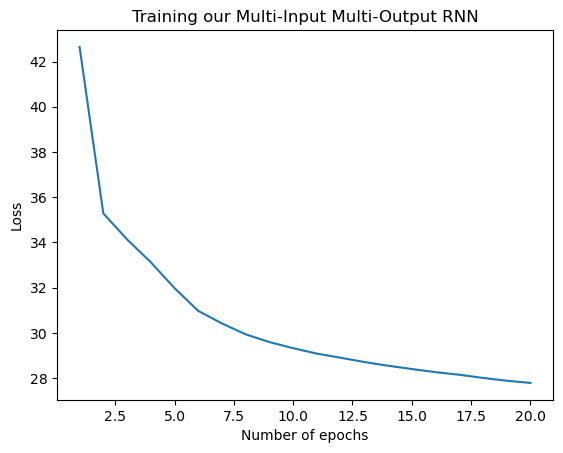

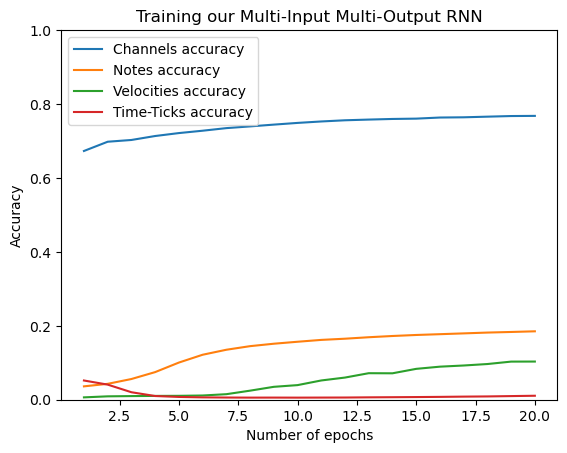

In [64]:
x = range(1,len(lossRNN)+1)
plt.figure()
plt.plot(x, lossRNN)
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracyRNN, label="Channels accuracy")
plt.plot(x, notes_accuracyRNN, label="Notes accuracy")
plt.plot(x, velocities_accuracyRNN, label="Velocities accuracy")
plt.plot(x, ticks_accuracyRNN, label="Time-Ticks accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()

In [14]:
dim = 300

lossLSTM = []
channels_accuracyLSTM = []
notes_accuracyLSTM = []
velocities_accuracyLSTM = []
ticks_accuracyLSTM = []

# Define input layers for notes and velocities
#input_channels = Input(shape=(None, n_Channels))
#input_notes = Input(shape=(None, n_Notes))
#input_velocities = Input(shape=(None, 1))
#input_ticks = Input(shape=(None, 1))

# Define LSTM layer
lstm_output = LSTM(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_ticks]))

# Define Dense layer for each branch
channels_output_lstm = Dense(units=n_Channels)(lstm_output)
notes_output_lstm = Dense(units=n_Notes)(lstm_output)
velocities_output_lstm = Dense(units=1)(lstm_output)
ticks_output_lstm = Dense(units=1)(lstm_output)

# Use Lambda layer to split the output of SimpleLSTM into two branches
lstm_final_channels = Softmax(name="Channels")(channels_output_lstm)
lstm_final_notes = Softmax(name="Notes")(notes_output_lstm)
lstm_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_lstm)
lstm_final_ticks = Lambda(lambda x: (tf.sigmoid(x) * (tick_range[1] - tick_range[0]) + tick_range[0]), name="Time-Ticks")(ticks_output_lstm)

# Define the model with inputs and outputs
LSTM_model = Model(inputs=[input_channels, input_notes, input_velocities, input_ticks], outputs=[lstm_final_channels, lstm_final_notes, lstm_final_velocities, lstm_final_ticks], name="LSTM_model")

LSTM_model.summary()

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                         

In [19]:
n_epochs = 17

lossesLSTM = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Time-Ticks': 'mean_squared_error'
}


loss_weightsLSTM = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Time-Ticks': 2e-7
}

metricsLSTM = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Time-Ticks': rounded_accuracy
}

LSTM_model.compile(optimizer='adam', loss=lossesLSTM, loss_weights=loss_weightsLSTM, metrics=metricsLSTM)
history = LSTM_model.fit([X_channels, X_notes, X_velocities, X_ticks], [y_channels, y_notes, y_velocities, y_ticks], epochs=n_epochs, batch_size=n_batch)

lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']
velocities_accuracyLSTM += history.history['Velocities_rounded_accuracy']
ticks_accuracyLSTM += history.history['Time-Ticks_rounded_accuracy']

Epoch 1/17
358/358 [==============================] - 84s 222ms/step - loss: 29.1874 - Channels_loss: 0.5201 - Notes_loss: 3.1560 - Velocities_loss: 657.2759 - Time-Ticks_loss: 9674.0820 - Channels_accuracy: 0.7424 - Notes_accuracy: 0.1541 - Velocities_rounded_accuracy: 0.0144 - Time-Ticks_rounded_accuracy: 0.5087
Epoch 2/17
358/358 [==============================] - 78s 219ms/step - loss: 28.2970 - Channels_loss: 0.4935 - Notes_loss: 3.0498 - Velocities_loss: 639.9802 - Time-Ticks_loss: 9421.2188 - Channels_accuracy: 0.7546 - Notes_accuracy: 0.1762 - Velocities_rounded_accuracy: 0.0322 - Time-Ticks_rounded_accuracy: 0.4918
Epoch 3/17
358/358 [==============================] - 79s 219ms/step - loss: 27.6954 - Channels_loss: 0.4790 - Notes_loss: 2.9880 - Velocities_loss: 625.6964 - Time-Ticks_loss: 9409.7910 - Channels_accuracy: 0.7634 - Notes_accuracy: 0.1915 - Velocities_rounded_accuracy: 0.0690 - Time-Ticks_rounded_accuracy: 0.3920
Epoch 4/17
358/358 [==============================] 

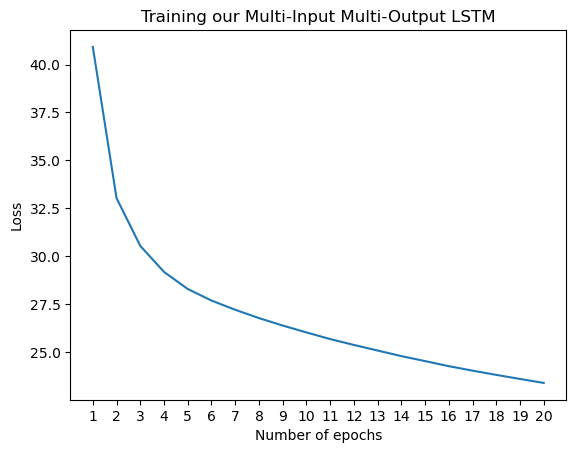

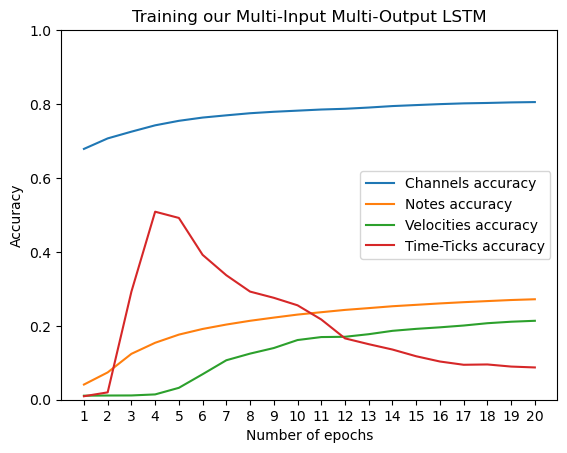

In [20]:
x = range(1,len(lossLSTM)+1)
plt.figure()
plt.plot(x, lossLSTM)
plt.title("Training our Multi-Input Multi-Output LSTM")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracyLSTM, label="Channels accuracy")
plt.plot(x, notes_accuracyLSTM, label="Notes accuracy")
plt.plot(x, velocities_accuracyLSTM, label="Velocities accuracy")
plt.plot(x, ticks_accuracyLSTM, label="Time-Ticks accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output LSTM")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()